In [3]:
import qiskit as qk
import numpy as np
from qiskit.tools.visualization import plot_histogram
from qiskit import IBMQ
from qiskit.tools.monitor import job_monitor
from qiskit.providers.aer.noise import NoiseModel
import matplotlib
import matplotlib.pyplot as plt
from qiskit.visualization import plot_bloch_multivector
from qiskit.tools.monitor import job_monitor
from qiskit import pulse              
from qiskit.circuit import Parameter 
from IPython.display import display
from qiskit import pulse
from qiskit import QuantumCircuit
from qiskit.circuit import Gate
import warnings
warnings.filterwarnings('ignore')
from qiskit.tools.jupyter import *
# The pulse simulator
from qiskit.providers.aer import PulseSimulator
import Su22
import qiskit
from qiskit.providers.fake_provider import FakeOpenPulse2Q,ConfigurableFakeBackend
from qiskit import transpile
backend = FakeOpenPulse2Q()
'''
# Object for representing physical models
from qiskit.providers.aer.pulse import PulseSystemModel
token = 'b6464d13b284902ed1d1a48d2aed6bd0474c7be45011741b0fb879614419659cb722e74a046af3d5caae0398aec9bdac8843068ecbee91aff466cf3e30f3bef5'
try:
    IBMQ.load_account()
except:
    qk.IBMQ.save_account(token=token)
    qk.IBMQ.enable_account(token)
provider = IBMQ.get_provider(hub="ibm-q", group="open", project="main")
backend = provider.get_backend("ibmq_armonk")
'''

'\n# Object for representing physical models\nfrom qiskit.providers.aer.pulse import PulseSystemModel\ntoken = \'b6464d13b284902ed1d1a48d2aed6bd0474c7be45011741b0fb879614419659cb722e74a046af3d5caae0398aec9bdac8843068ecbee91aff466cf3e30f3bef5\'\ntry:\n    IBMQ.load_account()\nexcept:\n    qk.IBMQ.save_account(token=token)\n    qk.IBMQ.enable_account(token)\nprovider = IBMQ.get_provider(hub="ibm-q", group="open", project="main")\nbackend = provider.get_backend("ibmq_armonk")\n'

In [4]:
test=Su22.loadData("FGRAFS_controls/x_gate_sampling.p")
from qiskit.providers.aer import PulseSimulator
from qiskit.compiler import assemble
signal = Su22.Custom_Fgp('low_freq',test,backend)
temp = signal.Customize_pulse(1)
#with pulse.build(backend=backend) as pulse_2:
    #pulse.play(pulse.Gaussian(duration=1000,amp=1,sigma=1000, name='Rabi Pulse'), pulse.drive_channel(0))
#    pulse.call(temp,pulse.drive_channel(0))
    
#print(signal.input)
#print(signal.norm)
#a=block_to_schedule(signal.Customize_pulse(1))
#result = transpile(a,
 #                    backend=backend, 
 #                    )
#results =backend.run(result, shots = 100).result()
#print(results.get_counts())
signal.draw()

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

In [ ]:
drive_amp = Parameter('drive_amp')
with pulse.build(backend=backend, default_alignment='sequential', name='Rabi Experiment') as pulse_1:
    pulse.play(pulse.Gaussian(duration=1000,amp=6*drive_amp,sigma=1000, name='Rabi Pulse'), pulse.drive_channel(0))
temp=Su22.Probe_Pulse(pulse_1,drive_amp,10)
with pulse.build(backend=backend, default_alignment='sequential', name='Rabi Experiment') as pulse_2:
    pulse.play(pulse.Gaussian(duration=1000,amp=1,sigma=1000, name='Rabi Pulse'), pulse.drive_channel(0))
    pulse.call(temp[4],pulse.drive_channel(0))
pulse_2.draw(backend=backend)

In [3]:
hel = np.array([0,1,2,3,4,5,6])
hel = hel*drive_amp
print(hel)

[ParameterExpression(0) ParameterExpression(drive_amp)
 ParameterExpression(2*drive_amp) ParameterExpression(3*drive_amp)
 ParameterExpression(4*drive_amp) ParameterExpression(5*drive_amp)
 ParameterExpression(6*drive_amp)]


In [4]:
with pulse.build(backend=backend, default_alignment='sequential', name='Rabi Experiment') as pulse_1:
    print(pulse.seconds_to_samples(2/9.00001*10**-9))

0


In [1]:
class Custom_Fgp:
    def __init__(self, name, inp,backend):
        self.name=name
        self.input = np.array(inp)
        self.backend = backend
        drive_sigma_sec = 0.015 * 1.0e-6                          # This determines the actual width of the gaussian
        drive_duration_sec = drive_sigma_sec   
        #self.norm = self.input/np.sqrt((self.input**2).sum())
        self.norm = self.input/self.input.max()
        self.par = Parameter('drive_amp')
        self.pi_p = 1
        

    def Create_Pulse(self):
        with pulse.build(backend=backend, default_alignment='sequential', name='Rabi Experiment') as custom_Pulse:
            [pulse.play(self.norm*self.pi_p, pulse.drive_channel(0))]
        return custom_Pulse
    
    def Customize_pulse(self,x):
        with qiskit.pulse.build(backend=backend, default_alignment='sequential', name='Rabi Experiment') as custom_Pulse:
            [pulse.play(self.norm*x, pulse.drive_channel(0))]
            pulse.measure(qubits=[0], registers=[pulse.MemorySlot(0)])
        return custom_Pulse
    
    def draw(self):
        return self.Create_Pulse().draw(backend=self.backend)
    
    def baseline_remove(self, values):
        return np.array(values) - np.mean(values)
    
    '''def rabi_test(self,num_rabi_points): #non functional
        scale_factor = 1e-15
        drive_amp_min = -1
        drive_amp_max = 1
        drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

        rabi_schedules = [self.cont.assign_parameters({self.par: a}, inplace=False) for a in drive_amps]
        num_shots_per_point = 1024
        job = backend.run(rabi_schedules, 
                  meas_level=1, 
                  meas_return='avg', 
                  shots=num_shots_per_point)
        job_monitor(job)
        
        rabi_results = job.result(timeout=120)
        rabi_values = []
        for i in range(num_rabi_points):
            # Get the results for `qubit` from the ith experiment
            rabi_values.append(rabi_results.get_memory(i)[0] * scale_factor)

        rabi_values = np.real(self.baseline_remove(rabi_values))

        return drive_amps,rabi_values'''
    
    def Cali(self,num_rabi_points):
        scale_factor = 1e-15
        drive_amp_min = -1
        drive_amp_max = 1
        drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

        rabi_schedules = [self.Customize_pulse(a) for a in drive_amps]
        #return rabi_schedules
        num_shots_per_point = 1024
        job = backend.run(rabi_schedules, 
                  meas_level=1, 
                  meas_return='avg', 
                  shots=num_shots_per_point)
        job_monitor(job)
        
        rabi_results = job.result(timeout=120)
        rabi_values = []
        for i in range(num_rabi_points):
            # Get the results for `qubit` from the ith experiment
            rabi_values.append(rabi_results.get_memory(i)[0] * scale_factor)

        rabi_values = np.real(self.baseline_remove(rabi_values))

        return drive_amps,rabi_values
    
    def rabi_test_Sim(self,num_rabi_points):
        scale_factor = 1e-15
        drive_amp_min = -1
        drive_amp_max = 1
        drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

        rabi_schedules = [self.Customize_pulse(a) for a in drive_amps]
        #return rabi_schedules
        num_shots_per_point = 1024
        armonk_model = PulseSystemModel.from_backend(self.backend)
        backend_sim = PulseSimulator(system_model=armonk_model)

        rabi_qobj = assemble(rabi_schedules, 
                             backend=backend_sim,
                             meas_level=1, 
                             meas_return='avg',
                             shots=num_shots_per_point)
        sim_result = backend_sim.run(rabi_qobj).result()
        rabi_values = []
        for i in range(num_rabi_points):
            # Get the results for `qubit` from the ith experiment
            rabi_values.append(sim_result.get_memory(i)[0] * scale_factor)

        rabi_values = np.real(self.baseline_remove(rabi_values))
        return drive_amps,rabi_values
    
    def add_as_gate(self,circ,qubits):
        custom_gate = Gate(self.name, 1,[])
        [circ.append(custom_gate, [i]) for i in qubits]
        circ.add_calibration(self.name, qubits, self.Create_Pulse(), [])
        return circ

In [2]:
import Su22
import qiskit
from qiskit.providers.fake_provider import FakeOpenPulse2Q,ConfigurableFakeBackend
from qiskit import transpile
backend = FakeOpenPulse2Q()

#pulse = Su22.loadData("FGRAFS_controls/x_gate_sampling.p")
#data= Su22.Spec(pulse,0.02,0.98,1,option=1)

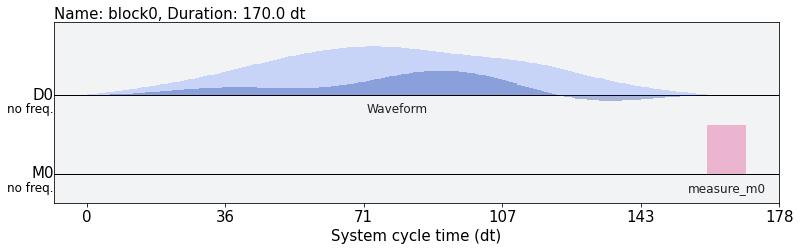

In [4]:
data.circ_batch[0].draw()

In [2]:
rabi_qobj = transpile(t, 
                      backend=backend)
results = backend.run(rabi_qobj,shots = 100).result()
print(results.get_counts())

NameError: name 't' is not defined

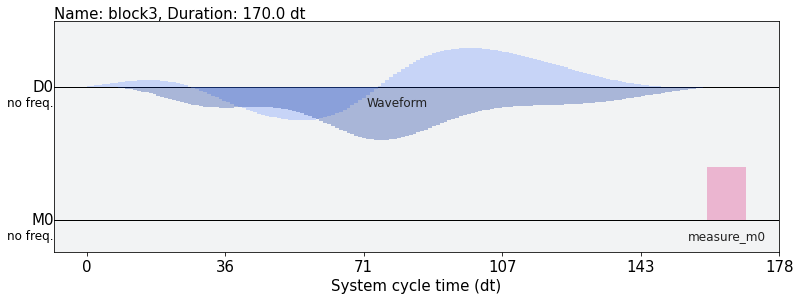

In [7]:
t.draw()

In [41]:
len(Su22.loadData("FGRAFS_controls/x_gate_sampling.p"))

160

In [3]:
from qiskit.providers.fake_provider import FakeOpenPulse2Q,ConfigurableFakeBackend
#backend = ConfigurableFakeBackend("memer",1)
backend = FakeOpenPulse2Q()
test2 =np.random.randint(20,size=200)
#print(signal.input)
#print(signal.norm)
signal.Customize_pulse(1).draw()

NameError: name 'signal' is not defined

In [93]:
print(Su22.get_closest_multiple_of_16(8))

16


In [57]:
test= Su22.loadData("FGRAFS_controls/x_gate_sampling.p")

In [58]:
import numpy as np
np.trapz(test)*0.2

(3.04373813019516+0j)

In [45]:
from qiskit.pulse.transforms import block_to_schedule
n= test[1]
n

array([[0.02, 0.84]])

[-4.04909147e-02  1.91645484e-02  3.37642693e+00 -3.03222218e-03]


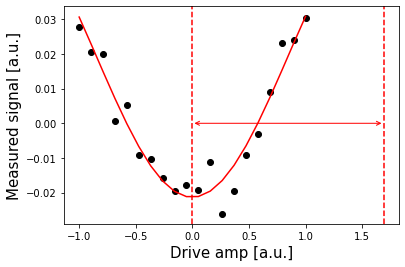

In [38]:
fit_params, y_fit = fit_function(drive_amps,
                                 rabi_values, 
                                 lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                 [-0.02, 0, 2, 0])

plt.scatter(drive_amps, rabi_values, color='black')
plt.plot(drive_amps, y_fit, color='red')
print(fit_params)
drive_period = fit_params[2] # get period of rabi oscillation

plt.axvline(0, color='red', linestyle='--')
plt.axvline(drive_period/2, color='red', linestyle='--')
plt.annotate("", xy=(0, 0), xytext=(drive_period/2,0), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(drive_period/2-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.show()

In [20]:
from qiskit.compiler import assemble
drive_amps_2,rabi_values_2 = signal.rabi_test_Sim(50)

[-7.31240863e-17  3.17874723e-17  2.00000001e+00  2.78077319e-10]


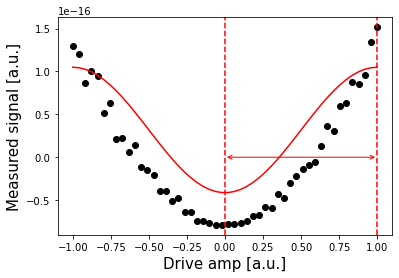

In [21]:
fit_params_2, y_fit_2 = fit_function(drive_amps_2,
                                 rabi_values_2, 
                                 lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                 [-8, 1, 2, 0])

plt.scatter(drive_amps_2, rabi_values_2, color='black')
plt.plot(drive_amps_2, y_fit_2, color='red')
print(fit_params_2)
drive_period_2 = fit_params_2[2] # get period of rabi oscillation

plt.axvline(0, color='red', linestyle='--')
plt.axvline(drive_period_2/2, color='red', linestyle='--')
plt.annotate("", xy=(0, 0), xytext=(drive_period_2/2,0), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(drive_period_2/2-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.show()

In [15]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    return fitparams, y_fit

In [ ]:
tester = signal.rabi_test_2(10)
with pulse.build(backend=backend) as pulse_2:
    #pulse.play(pulse.Gaussian(duration=1000,amp=1,sigma=1000, name='Rabi Pulse'), pulse.drive_channel(0))
    [pulse.call(tester[i],pulse.drive_channel(0)) for i in range(2)]
pulse_2.draw()

In [30]:
circ = QuantumCircuit(7,1)
circ.x([0])
circ.h([0,3,5])
circ.cx(0,1)
circ = signal.add_as_gate(circ,[0,1,2])
circ.draw('mpl')

AttributeError: 'numpy.ndarray' object has no attribute 'build'

In [22]:
import qiskit
from qiskit_experiments.framework import ParallelExperiment
from qiskit_experiments.library import StateTomography

# For simulation
from qiskit.providers.aer import AerSimulator
from qiskit.test.mock import FakeArmonk

# Noisy simulator backend
backend_2 = AerSimulator.from_backend(FakeArmonk())
nq = 1
qc_ghz = qiskit.QuantumCircuit(nq)
signal.add_as_gate(circ,[0])


# QST Experiment
qstexp1 = StateTomography(qc_ghz)
qstdata1 = qstexp1.run(backend_2, seed_simulation=100).block_for_results()

# Print results
for result in qstdata1.analysis_results():
    print(result)


DbAnalysisResultV1
- name: state
- value: DensityMatrix([[ 0.96875 +0.j        , -0.015625-0.00878906j],
               [-0.015625+0.00878906j,  0.03125 +0.j        ]],
              dims=(2,))
- extra: <5 items>
- device_components: ['Q0']
- verified: False
DbAnalysisResultV1
- name: state_fidelity
- value: 0.9687500000000001
- device_components: ['Q0']
- verified: False
DbAnalysisResultV1
- name: positive
- value: True
- device_components: ['Q0']
- verified: False


In [23]:
nq = 1
qc_ghz = qiskit.QuantumCircuit(nq)
qc_ghz.x(0)


# QST Experiment
qstexp1 = StateTomography(qc_ghz)
qstdata1 = qstexp1.run(backend_2, seed_simulation=100).block_for_results()

# Print results
for result in qstdata1.analysis_results():
    print(result)

DbAnalysisResultV1
- name: state
- value: DensityMatrix([[ 0.0234375 +0.j      , -0.00585938-0.015625j],
               [-0.00585938+0.015625j,  0.9765625 +0.j      ]],
              dims=(2,))
- extra: <5 items>
- device_components: ['Q0']
- verified: False
DbAnalysisResultV1
- name: state_fidelity
- value: 0.9765625000000002
- device_components: ['Q0']
- verified: False
DbAnalysisResultV1
- name: positive
- value: True
- device_components: ['Q0']
- verified: False
